In [7]:
# Import functional libraries
import numpy as np
import pandas as pd
import time

# Import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import dataloaders
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import visualization tools
import matplotlib.pyplot as plt

In [8]:
# Create Model class
class Model(nn.Module):
    def __init__(self, in_features=4, h1=10, h2=11, out_features=3):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(in_features,h1)
        # hidden layer
        self.fc2 = nn.Linear(h1, h2)
        # output layer
        self.out = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [9]:
# Set seed for reproducability
torch.manual_seed(42)

# Instantiate model class
model = Model()

In [10]:
# Dataset taken from Kaggle: https://www.kaggle.com/datasets/arshid/iris-flower-dataset?select=IRIS.csv
df = pd.read_csv('./data/IRIS.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [11]:
# Numercalize 'species' column into 'result' column
df['species'] = df['species'].astype('category')
df['result'] = df['species'].cat.codes

# Labels will be used in data visualization
labels = dict(enumerate(df['species'].cat.categories))

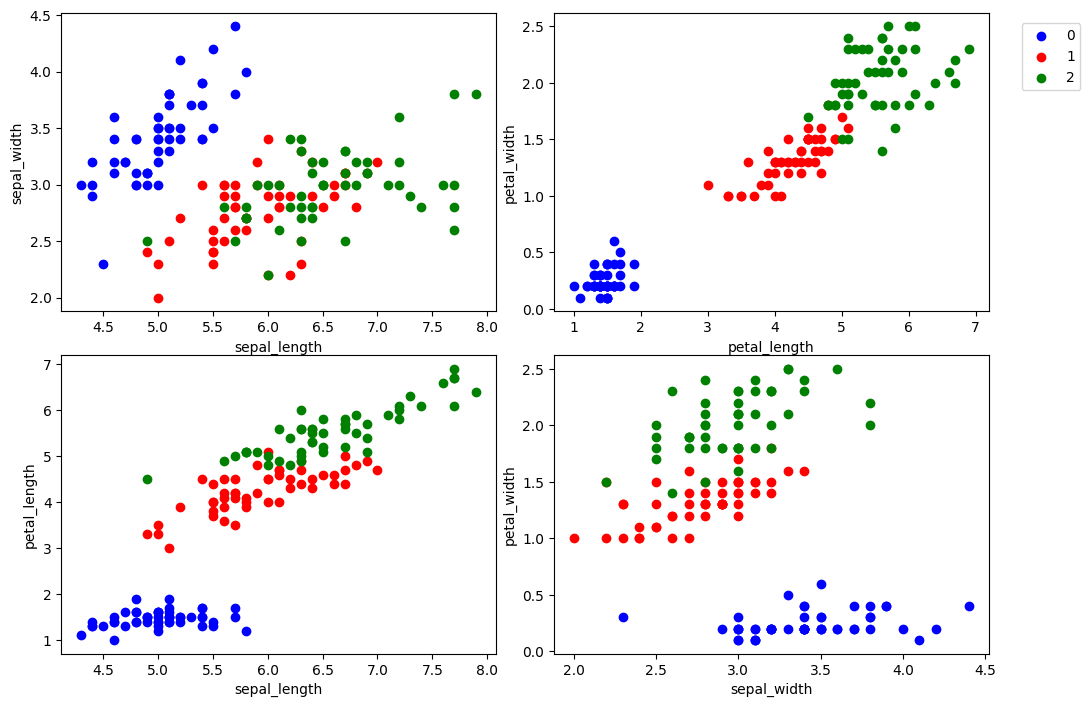

In [12]:
# Plot Dataset
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['result']==j][x], df[df['result']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [13]:
# Split data into training and testing sets
X = df.drop(['species', 'result'],axis=1).values
y = df['result'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# We expect float values for the inputs
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# We expect integer values for the inputs
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [14]:
# create Dataloader objects
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
testloader = DataLoader(X_test, batch_size=60, shuffle=False)

In [15]:
# Create loss and optimizer functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
# Train Model
epochs = 100
losses = []

# Track time
start_time = time.time()

# Loop through epochs
for i in range(epochs):
    i+=1
    # Make prediction matrix
    y_pred = model.forward(X_train)
    # Calculate loss
    loss = criterion(y_pred, y_train)
    # Save losses for data analysis
    losses.append(loss.item())
    
    # Start logging on first epoch:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f} time: {time.time() - start_time}')

    # Clear gradients
    optimizer.zero_grad()
    # Calculate new gradients
    loss.backward()
    # Apply new parameters to Model
    optimizer.step()

epoch:  1  loss: 1.08168244 time: 0.0009984970092773438
epoch: 11  loss: 0.89051682 time: 0.011966466903686523
epoch: 21  loss: 0.72704160 time: 0.018949031829833984
epoch: 31  loss: 0.58689481 time: 0.02493143081665039
epoch: 41  loss: 0.39446175 time: 0.033940792083740234
epoch: 51  loss: 0.23838906 time: 0.04088854789733887
epoch: 61  loss: 0.13138247 time: 0.04786992073059082
epoch: 71  loss: 0.08657340 time: 0.05585074424743652
epoch: 81  loss: 0.07059278 time: 0.06283187866210938
epoch: 91  loss: 0.06402083 time: 0.06881546974182129


Text(0.5, 0, 'epoch')

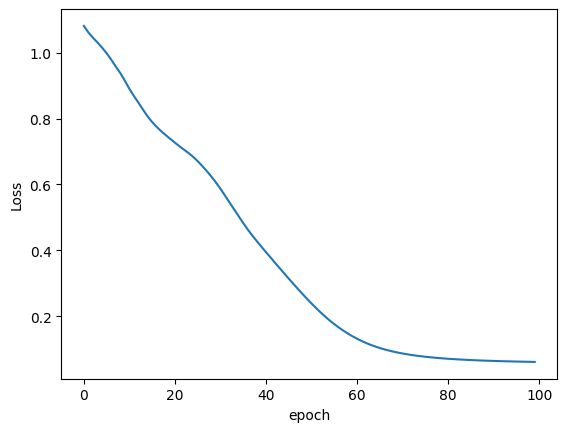

In [17]:
# Visualize loss over epoch
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch')

In [18]:
# Evaluate Test Set
# Prevent gradient updates to test set since model is already trained
with torch.no_grad():
    correct = 0
    for i,data in enumerate(X_test):
        # Make prediction matrix
        y_pred = model.forward(data)
        # Calculate loss (can be used for confidence scoring)
        loss = criterion(y_pred, y_test[i])
        # Print formatted comparisons for each test case
        if y_pred.argmax().item() == y_test[i]:
            correct += 1
            print(f'{i+1:2}. {"[Correct]":<12} Guess: {labels[int((y_pred).argmax())]:<15}  Answer: {labels[int(y_test[i])]:<15} Loss: {loss:.8f}')
        else:
            print(f'{i+1:2}. {"[Incorrect]":<12} Guess: {labels[int((y_pred).argmax())]:<15}  Answer: {labels[int(y_test[i])]:<15} Loss: {loss:.8f}')
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. [Correct]    Guess: Iris-versicolor  Answer: Iris-versicolor Loss: 0.01414699
 2. [Correct]    Guess: Iris-setosa      Answer: Iris-setosa     Loss: 0.00140699
 3. [Correct]    Guess: Iris-virginica   Answer: Iris-virginica  Loss: 0.00000083
 4. [Correct]    Guess: Iris-versicolor  Answer: Iris-versicolor Loss: 0.02929775
 5. [Correct]    Guess: Iris-versicolor  Answer: Iris-versicolor Loss: 0.01482823
 6. [Correct]    Guess: Iris-setosa      Answer: Iris-setosa     Loss: 0.00225290
 7. [Correct]    Guess: Iris-versicolor  Answer: Iris-versicolor Loss: 0.00504483
 8. [Correct]    Guess: Iris-virginica   Answer: Iris-virginica  Loss: 0.08082844
 9. [Incorrect]  Guess: Iris-virginica   Answer: Iris-versicolor Loss: 0.74118060
10. [Correct]    Guess: Iris-versicolor  Answer: Iris-versicolor Loss: 0.00243712
11. [Correct]    Guess: Iris-virginica   Answer: Iris-virginica  Loss: 0.37732041
12. [Correct]    Guess: Iris-setosa      Answer: Iris-setosa     Loss: 0.00291613
13. [Correct]   

In [19]:
# Save trained model to file
# Using model.state_dict() since model is still defined, would use model.save(model, PATH) otherwise
torch.save(model.state_dict(), 'IRISModel.pt')

In [20]:
# Load trained model
new_model = Model()
# Apply saved parameters to model
new_model.load_state_dict(torch.load('IRISModel.pt'))
# Set new_model layers to evaluation mode
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=11, bias=True)
  (out): Linear(in_features=11, out_features=3, bias=True)
)

In [21]:
# Input new sample data into our model
new_sample = torch.tensor([5.4,3.8,2.1,0.4])

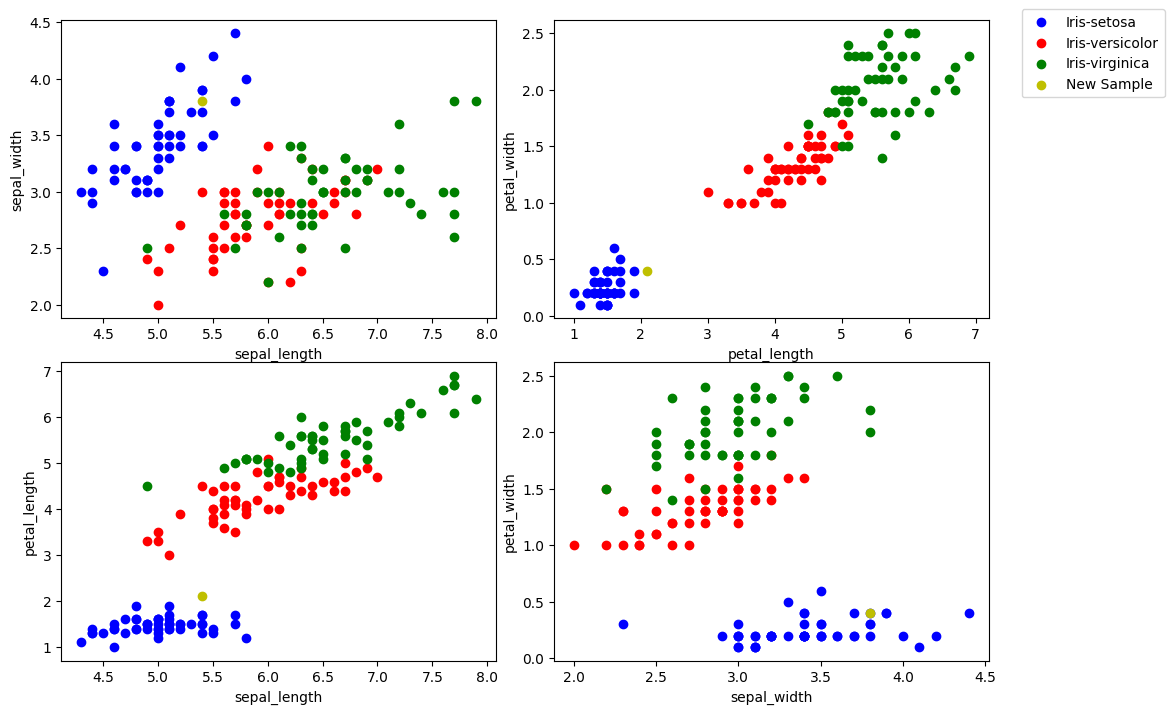

In [22]:
# Plot Dataset with new sample
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
# Add label for new sample
labels[4] = 'New Sample'

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['result']==j][x], df[df['result']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our new sample:
    ax.scatter(new_sample[plots[i][0]],new_sample[plots[i][1]], color='y')
    
fig.legend(labels=labels.values(), loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [23]:
# Run new sample data into our model
with torch.no_grad():
    print(f'Guess: {labels[int(new_model(new_sample).argmax())]}')
    

Guess: Iris-setosa
